Model trained on contaxts being normalised code. 

In [1]:
from transformers import (
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    keras_callbacks,
    TFAutoModelForSeq2SeqLM,
)
import tensorflow as tf
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from huggingface_hub import notebook_login
from datasets import concatenate_datasets
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, generative_qa_utils
from question_answering.paths import generative_qa_paths
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback

In [2]:
df_train, df_val, df_test = core_qa_utils.load_datasets_from_csv(
    generative_qa_paths.python_dataset_dir
)

df_train = pd.concat([df_train, df_val], ignore_index=True)

train_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_test]
)

code_type = 'original_code'
code_type = 'code'

In [3]:
model_checkpoint = "facebook/bart-base"
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")

In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["questions"].strip()
    context = sample[code_type].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)

tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/63080 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1475 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Max number of tokens in tokenized train dataset:  9473
Max number of tokens in tokenized test dataset:  792


In [5]:
max_length = 256


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x00000220B69BBED0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  63080
Number of samples in tokenized test dataset before filtering:  2500

---------------

Number of samples in tokenized train dataset after filtering:  62547
Number of samples in tokenized test dataset after filtering:  2481


In [7]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["questions"]]
    contexts = [c.strip() for c in dataset[code_type]]
    answers = [c.strip() for c in dataset["answers"]]

    inputs = tokenizer(
        questions,
        contexts,
        text_target=answers,
        max_length=max_length,
        truncation=True
    )

    return inputs

In [8]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/62547 [00:00<?, ? examples/s]

Map:   0%|          | 0/2481 [00:00<?, ? examples/s]

In [9]:
# Model parameters
training_number = 4

model_name = "python-bart-normalised"
full_model_name = f"{model_name}-{training_number}"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    generative_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = generative_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = generative_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = generative_qa_paths.model_evaluation_dir / full_model_name

# Hyperparameters
batch_size = 8
train_epochs = 5
initial_learning_rate = 3e-5 
end_learning_rate = 0.0

In [10]:
# Load model for fine-tuning
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFBartForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [11]:
# Dataset preparation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

tf_train_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_train_dataset,
    collator=data_collator,
    batch_size=batch_size,
    shuffle=True
)

tf_test_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_test_dataset,
    collator=data_collator,
    batch_size=batch_size,
)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

time_measure_cb = TimeMeasureCallback()

callbacks = [
    checkpoint_cb,
    # push_to_hub,
    time_measure_cb
]

In [13]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate, 
    end_learning_rate=end_learning_rate, 
    decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [14]:
model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLaye  multiple                 50265     
 r)                                                              
                                                                 
Total params: 139,470,681
Trainable params: 139,420,416
Non-trainable params: 50,265
_________________________________________________________________


In [15]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/5
7818/7818 [==============================] - ETA: 0s - loss: 2.7627
Epoch 1: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-normalised-4\cp-01.ckpt
7818/7818 [==============================] - 976s 121ms/step - loss: 2.7627
Epoch 2/5
7818/7818 [==============================] - ETA: 0s - loss: 2.1611
Epoch 2: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-normalised-4\cp-02.ckpt
7818/7818 [==============================] - 943s 121ms/step - loss: 2.1611
Epoch 3/5
7818/7818 [==============================] - ETA: 0s - loss: 1.8148
Epoch 3: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-normalised-4\cp-03.ckpt
7818/7818 [==============================] - 933s 119ms/step - loss: 1.8148
Epoch 4/5
7818/7818 [==============================] - ETA: 0s - loss: 1.5641
Epoch 4: saving model to e:\STUDIA\IPS\question-answering\generative-qa\t

In [16]:
# Get best version of the model
best_model, best_epoch = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, metric="loss", remove_checkpoints=True, model_type="generative"
)

In [17]:
# Save best model's weights
generative_qa_utils.save_model(best_model, model_name=full_model_name)

In [18]:
loaded_weights_model = generative_qa_utils.load_weights_into_model(
    model=model, 
    model_name=full_model_name
)

In [19]:
# Get predictions from the best model
loaded_model_evaluation = loaded_weights_model.evaluate(tf_test_dataset)

311/311 [==============================] - 27s 63ms/step - loss: 2.6331


In [20]:
parts_number = 100

test_dataset_pandas = tokenized_test_dataset.to_pandas()
test_dataset_array = np.array_split(test_dataset_pandas, parts_number)

test_datasets_list = []

for row in tqdm(test_dataset_array):
    test_datasets_list.append(core_qa_utils.prepare_tf_dataset(
        model=model,
        hf_dataset=Dataset.from_pandas(row),
        collator=data_collator,
        batch_size=batch_size,
))

c:\Users\Artur\.conda\envs\question_answering\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


In [29]:
# questions_and_answers_df = pd.DataFrame()
index_to_start_from = 78
predictions_list = []
labels_list = []
question_contexts_list = []

i = 0
for dataset in tqdm(test_datasets_list):
    if i < index_to_start_from:
        i = i + 1
        continue
    for batch, labels in tqdm(dataset):
        predictions = generative_qa_utils.generate_predictions(model, batch, max_length)
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = [prediction.strip() for prediction in decoded_predictions]
        decoded_labels = [label.strip() for label in decoded_labels]
        predictions_list.extend(decoded_predictions)
        labels_list.extend(decoded_labels)
        question_contexts_list.extend(tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True))

        data = {
            'question_contexts': tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True),
            'labels': decoded_labels,
            'predictions': decoded_predictions
        }
        questions_and_answers_df = pd.concat([questions_and_answers_df, pd.DataFrame(data)], ignore_index=True)
    i = i + 1

100%|██████████| 100/100 [07:13<00:00,  4.33s/it]


In [31]:
dataset_dataframe_with_predictions = generative_qa_utils.split_questions_and_contexts_into_two_columns(dataframe=questions_and_answers_df)
dataset_dataframe_with_predictions

,questions,contexts,labels,predictions
0,How does the code add a user in the given buck...,def add bucket default owner bucket name user ...,as an owner,by email
1,Does the code add a user in the given buckets ...,def add bucket default owner bucket name user ...,Yes,Yes
2,Where does the code add a user as an owner?,def add bucket default owner bucket name user ...,in the given buckets default object access con...,in a bucket
3,Does the code create a simple sdist tarball at...,def make trivial sdist dist path setup py setu...,Yes,Yes
4,How does the code create a simple sdist tarball?,def make trivial sdist dist path setup py setu...,at dist_path,with trivial setup
...,...,...,...,...
2459,What do the sequence contain?,def all bases valid seq valid bases ['a' 'A' '...,only bases,all valid bases
2460,What created this variable?,def get brick var return get annotation var Brick,the brick,the class
2461,What does the code retrieve?,def get brick var return get annotation var Brick,the brick that created this variable,the value of a brick variable
2462,What does approximate joint diagonalization im...,def test ajd n times n channels 10 3 seed np r...,same results as the matlab implementation by p...,an approximation of the inverse of ajd


In [32]:
bleu_result, rogue_result, meteor_result= generative_qa_utils.get_metrics(dataset_dataframe_with_predictions)
print(
    "BLEU:\n",
    bleu_result,
    "\nROGUE:\n",
    rogue_result,
    "\nMETEOR:\n",
    meteor_result
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU:
 {'bleu': 0.08406675522665394, 'precisions': [0.42173760112557157, 0.16108821104699092, 0.08875441250630359, 0.06252554147936248], 'brevity_penalty': 0.6033035915989431, 'length_ratio': 0.6643040735259755, 'translation_length': 8529, 'reference_length': 12839} 
ROGUE:
 {'rouge1': 0.357210248075379, 'rouge2': 0.11048963331939618, 'rougeL': 0.3472241267274743, 'rougeLsum': 0.3471388323335818} 
METEOR:
 {'meteor': 0.23605725004893546}


In [33]:
closed_questions_dictionary = generative_qa_utils.get_closed_questions_split_according_to_answer_correctness(dataframe=dataset_dataframe_with_predictions)

number_of_closed_questions = len(closed_questions_dictionary['closed_all'])
number_of_correct_answers = len(closed_questions_dictionary['closed_correct_answer'])
number_of_wrong_answers = len(closed_questions_dictionary['closed_wrong_answer'])

number_of_long_answers_for_closed_questions = len(closed_questions_dictionary['closed_long_answer'])

print("Correct answers: ", number_of_correct_answers)
print("Wrong answers: ", number_of_wrong_answers)
print("Long answers for closed questions: ", number_of_long_answers_for_closed_questions)
print("Wrong answers without the long ones: ", number_of_wrong_answers - number_of_long_answers_for_closed_questions)

Correct answers:  103
Wrong answers:  32
Long answers for closed questions:  0
Wrong answers without the long ones:  32


In [34]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation,
        "bleu": bleu_result,
        "rogue": rogue_result,
        "meteor": meteor_result,
        "closed_questions": {
            "closed_questions_number": number_of_closed_questions,
            "correct_answers_number": number_of_correct_answers,
            "wrong_answers_number": number_of_wrong_answers,
            "long_answers_for_closed_questions_number": number_of_long_answers_for_closed_questions,
        }
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [35]:
dataset_dataframe_with_predictions = generative_qa_utils.calculate_bleus_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_rouges_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_meteor_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions

2464it [00:45, 54.60it/s]
2464it [20:55,  1.96it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2464it [00:25, 95.22it/s] 


,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,How does the code add a user in the given buck...,def add bucket default owner bucket name user ...,as an owner,by email,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,Does the code add a user in the given buckets ...,def add bucket default owner bucket name user ...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
2,Where does the code add a user as an owner?,def add bucket default owner bucket name user ...,in the given buckets default object access con...,in a bucket,0.0,0.333333,0.0,0.166667,0.0,0.166667,0.119048
3,Does the code create a simple sdist tarball at...,def make trivial sdist dist path setup py setu...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
4,How does the code create a simple sdist tarball?,def make trivial sdist dist path setup py setu...,at dist_path,with trivial setup,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2459,What do the sequence contain?,def all bases valid seq valid bases ['a' 'A' '...,only bases,all valid bases,0.0,0.333333,0.0,0.400000,0.0,0.400000,0.238095
2460,What created this variable?,def get brick var return get annotation var Brick,the brick,the class,0.0,0.500000,0.0,0.500000,0.0,0.500000,0.250000
2461,What does the code retrieve?,def get brick var return get annotation var Brick,the brick that created this variable,the value of a brick variable,0.0,0.500000,0.0,0.500000,0.0,0.500000,0.250000
2462,What does approximate joint diagonalization im...,def test ajd n times n channels 10 3 seed np r...,same results as the matlab implementation by p...,an approximation of the inverse of ajd,0.0,0.142857,0.0,0.117647,0.0,0.117647,0.047170


In [36]:
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
prediction_counts_per_metric_range = generative_qa_utils.calculate_prediction_counts_per_metric_range(dataset_dataframe_with_predictions, thresholds)
prediction_counts_per_metric_range

{'bleu': [2401, 14, 14, 11, 24],
 'bleu1': [824, 440, 419, 295, 486],
 'bleu2': [1976, 136, 149, 49, 154],
 'rouge1': [887, 648, 408, 268, 253],
 'rouge2': [1969, 247, 102, 57, 89],
 'rougeL': [917, 670, 392, 235, 250],
 'meteor': [1431, 484, 279, 148, 122]}

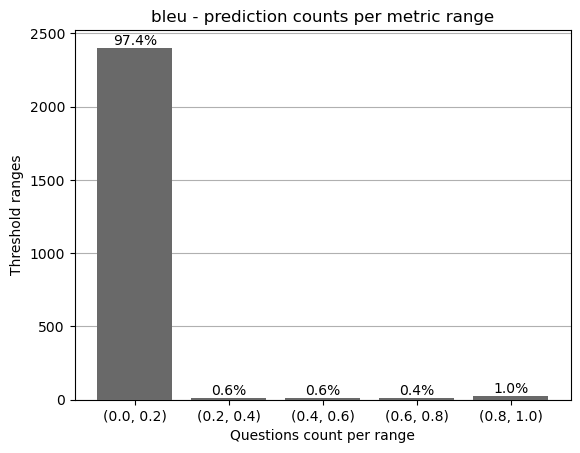

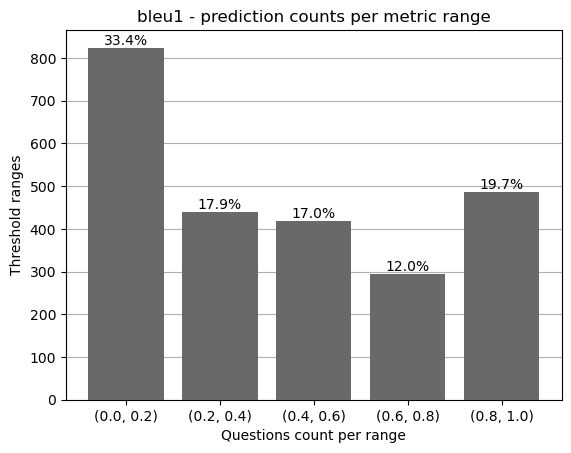

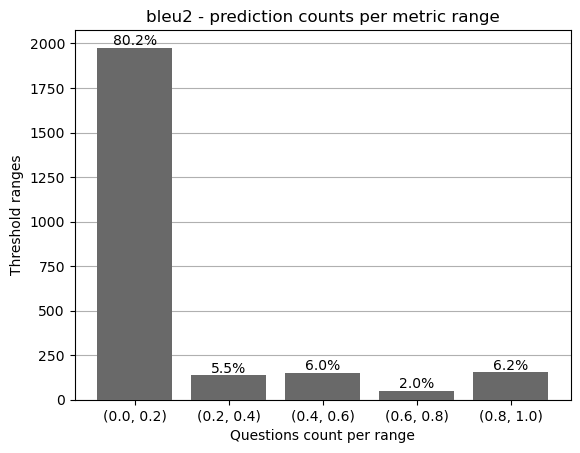

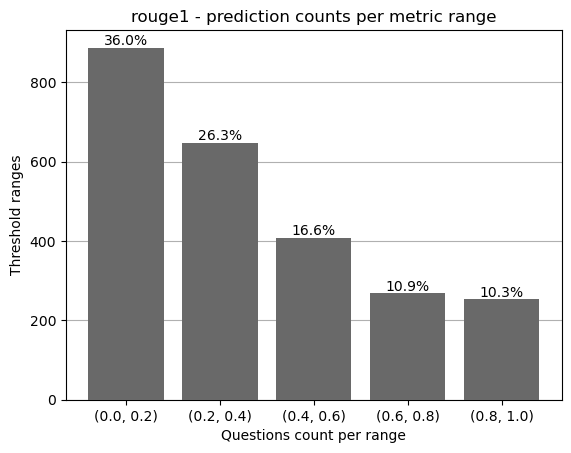

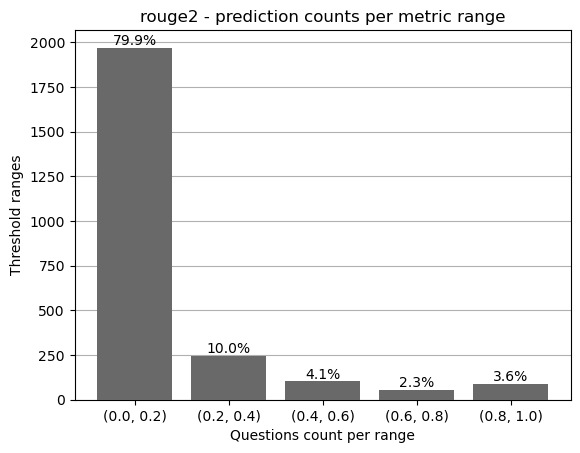

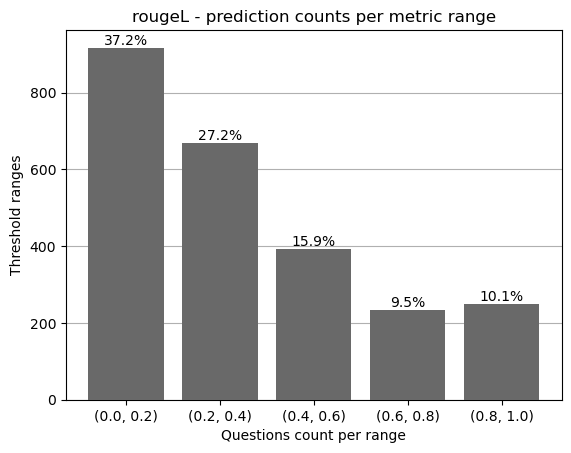

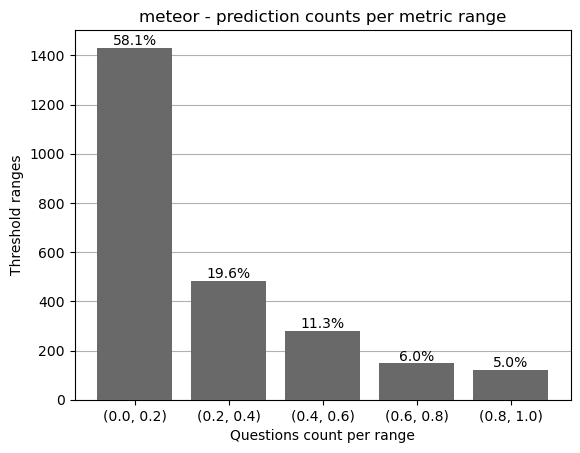

In [37]:
generative_qa_utils.plot_prediction_counts_per_metric_range_diagrams(
    prediction_counts_per_metric = prediction_counts_per_metric_range,
    thresholds=thresholds,
    figure_directory_path=model_evaluation_dir
    )

In [38]:
dataset_dataframe_with_predictions.to_csv(
    model_evaluation_dir / "test_set_sample_generation.csv", index=True, index_label="index"
)

In [39]:
dataset_dataframe_with_predictions = pd.read_csv(model_evaluation_dir / "test_set_sample_generation.csv")
dataset_dataframe_with_predictions

,index,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,0,How does the code add a user in the given buck...,def add bucket default owner bucket name user ...,as an owner,by email,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,1,Does the code add a user in the given buckets ...,def add bucket default owner bucket name user ...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
2,2,Where does the code add a user as an owner?,def add bucket default owner bucket name user ...,in the given buckets default object access con...,in a bucket,0.0,0.333333,0.0,0.166667,0.0,0.166667,0.119048
3,3,Does the code create a simple sdist tarball at...,def make trivial sdist dist path setup py setu...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
4,4,How does the code create a simple sdist tarball?,def make trivial sdist dist path setup py setu...,at dist_path,with trivial setup,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2459,What do the sequence contain?,def all bases valid seq valid bases ['a' 'A' '...,only bases,all valid bases,0.0,0.333333,0.0,0.400000,0.0,0.400000,0.238095
2460,2460,What created this variable?,def get brick var return get annotation var Brick,the brick,the class,0.0,0.500000,0.0,0.500000,0.0,0.500000,0.250000
2461,2461,What does the code retrieve?,def get brick var return get annotation var Brick,the brick that created this variable,the value of a brick variable,0.0,0.500000,0.0,0.500000,0.0,0.500000,0.250000
2462,2462,What does approximate joint diagonalization im...,def test ajd n times n channels 10 3 seed np r...,same results as the matlab implementation by p...,an approximation of the inverse of ajd,0.0,0.142857,0.0,0.117647,0.0,0.117647,0.047170


In [40]:
dataframe_predictions_and_question_types = generative_qa_utils.add_question_types_to_dataset_dataframe(dataset_predictions_dataframe=dataset_dataframe_with_predictions)

In [41]:
only_metric_columns_dataframe = dataframe_predictions_and_question_types[['bleu', 'bleu1', 'bleu2', 'rouge1', 'rouge2', 'rougeL', 'meteor', 'question_type']]
metric_mean_values_dataframe = only_metric_columns_dataframe.groupby(['question_type']).mean()
metric_mean_values_dataframe.insert(
    loc=0,
    column='question_type',
    value=list(only_metric_columns_dataframe.groupby(['question_type']).groups.keys())
)
metric_mean_values_dataframe.to_csv(
    model_evaluation_dir / "metric_mean_values.csv", index=False
)
metric_mean_values_dataframe

,question_type,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
question_type,,,,,,,,
closed,closed,0.000000,0.762963,0.000000,0.762963,0.000000,0.762963,0.381481
for_whats,for_whats,0.015806,0.365822,0.134649,0.295083,0.101460,0.289300,0.198861
hows,hows,0.010050,0.213281,0.065542,0.182672,0.057782,0.182672,0.121855
others,others,0.000000,0.445000,0.138889,0.378819,0.123783,0.378819,0.260083
whats,whats,0.020609,0.440195,0.149191,0.354322,0.126072,0.340661,0.241376
whens,whens,0.008799,0.232263,0.056579,0.212430,0.052141,0.209420,0.143377
wheres,wheres,0.012705,0.400138,0.142424,0.365485,0.127058,0.365485,0.256941


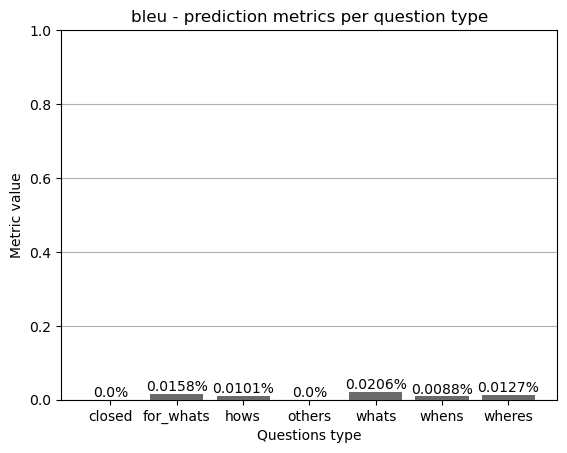

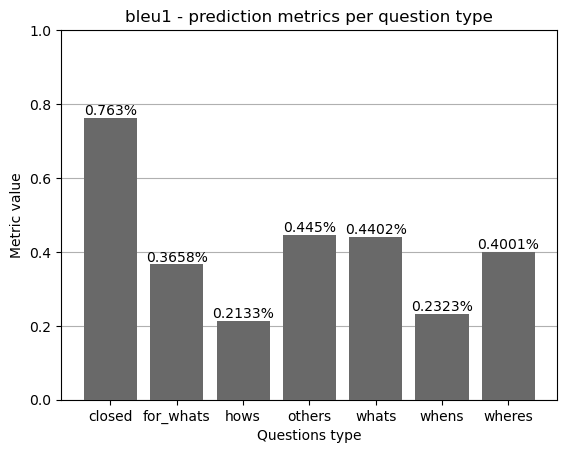

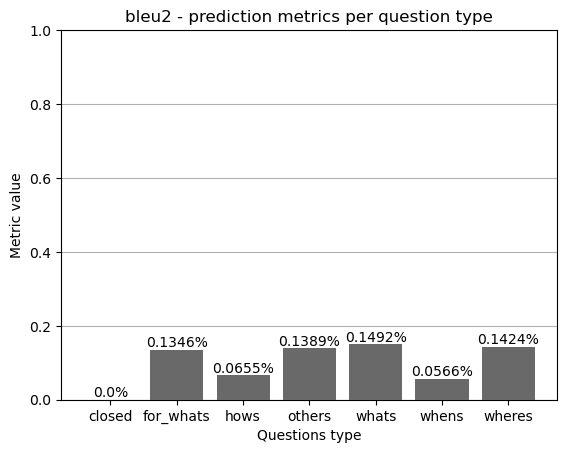

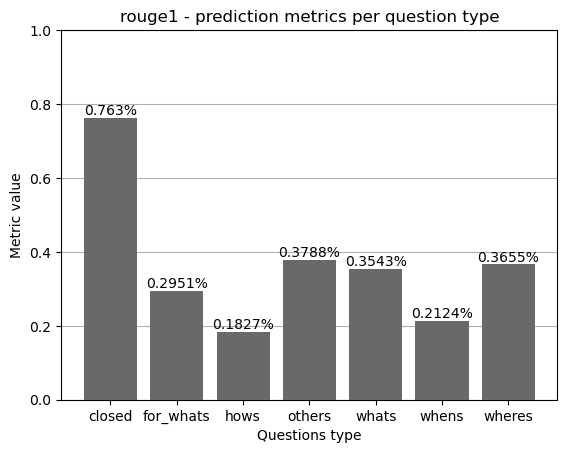

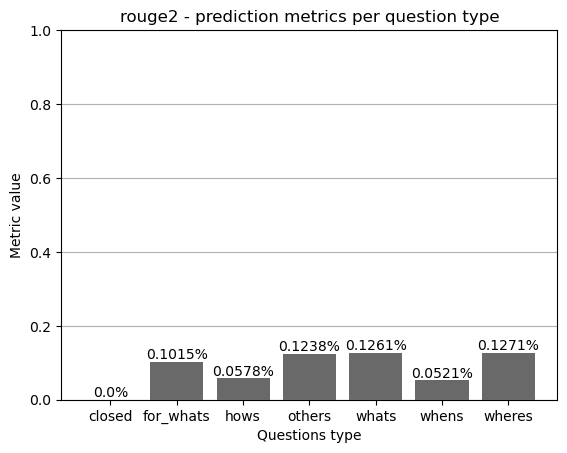

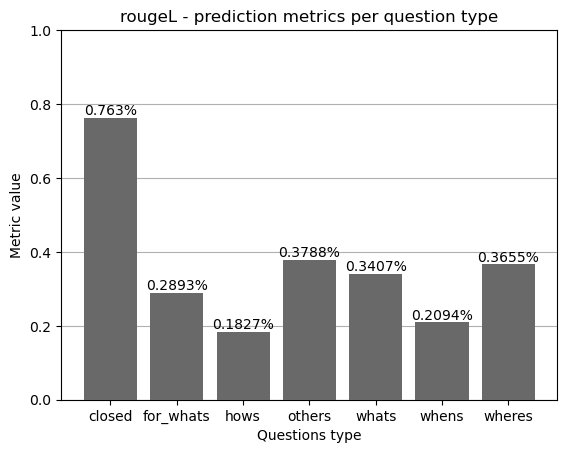

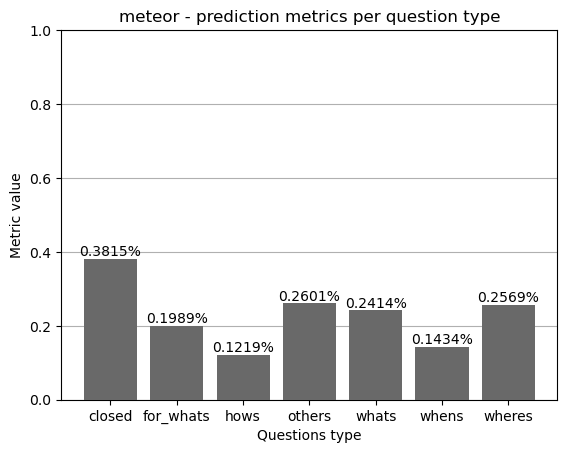

In [42]:
generative_qa_utils.plot_prediction_metrics_per_question_type_diagram(
    metric_mean_values_dataframe=metric_mean_values_dataframe,
    figure_directory_path=model_evaluation_dir / 'figures' / 'metrics-per-type'
)

In [43]:
question_type_metrics_dictionary = generative_qa_utils.count_prediction_numbers_per_metric_range_for_specific_question_type(dataframe_predictions_and_question_types)
generative_qa_utils.save_question_type_metrics_dictionary_to_csv(model_evaluation_dir=model_evaluation_dir, question_type_metrics_dictionary=question_type_metrics_dictionary)
question_type_metrics_dictionary = generative_qa_utils.read_question_type_metrics_dictionary_from_csv(model_evaluation_dir=model_evaluation_dir)
question_type_metrics_dictionary

{'whats':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)  1771    559   1421     614    1421     644    1053
 1      1  (0.2, 0.4)    13    341    110     526     191     547     404
 2      2  (0.4, 0.6)    13    345    120     330      87     314     146
 3      3  (0.6, 0.8)    10    240     40     232      53     200     122
 4      4  (0.8, 1.0)    20    342    136     125      75     122     102,
 'wheres':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)   119     32     92      35      91      35      72
 1      1  (0.2, 0.4)     0     38      8      41      20      41      22
 2      2  (0.4, 0.6)     1     19     13      21       3      21       8
 3      3  (0.6, 0.8)     0     16      1      13       1      13       9
 4      4  (0.8, 1.0)     1     16      7      11       6      11      10,
 'hows':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0

In [44]:
generative_qa_utils.plot_prediction_counts_per_metric_range_per_question_type_diagram(
    question_type_metrics_dictionary=question_type_metrics_dictionary,
    figure_directory_path=model_evaluation_dir / 'figures' / 'counts-per-metric-range'
)